# Analisis exploratorio - Applicant TC

## 1. Librerias y funciones

In [60]:
#!pip install optbinning

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from optbinning import OptimalBinning

#Configure Defaults
import warnings
import os
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
plt.rcParams["figure.figsize"] = 7,4

In [62]:
def q01(x): return x.quantile(0.01)
def q05(x): return x.quantile(0.05)
def q25(x): return x.quantile(0.25)
def q50(x): return x.quantile(0.50)
def q75(x): return x.quantile(0.75)
def q80(x): return x.quantile(0.80)
def q90(x): return x.quantile(0.90)
def q95(x): return x.quantile(0.95)
def q99(x): return x.quantile(0.99)
def desv(x): return np.std(x)


def Columnas_con_missing(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
    print ("La tabla seleccionada con " + str(df.shape[1]) + " columnas.\n" "Tiene " + str(mis_val_table_ren_columns.shape[0]) +" columnas con valores nulos.")
    return mis_val_percent.sort_values(ascending=False).head(mis_val_table_ren_columns.shape[0])

def correlation_heatmap(df, method):
    _ , ax = plt.subplots(figsize =(7,4))
    colormap = sns.diverging_palette(220, 10, as_cmap = True)
    
    _ = sns.heatmap(
        df.corr(method=method),
        cmap = colormap,
        square=True, 
        annot=True, 
        annot_kws={'fontsize':9 }
    )
    plt.title('Correlation Matrix', y=1.05, size=15)

## 2. Carga de datos

In [63]:
data =  pd.read_csv('./DATA/tc_applicant_target.csv',sep='|')

In [64]:
data.head(2)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0


In [65]:
# Control de duplicados
print(data['ID'].shape)
print(data['ID'].unique().shape)

(36457,)
(36457,)


In [66]:
# Control de missings
Columnas_con_missing(data)

La tabla seleccionada con 19 columnas.
Tiene 1 columnas con valores nulos.


OCCUPATION_TYPE    31.058507
dtype: float64

In [67]:
target = 'DEF_30D_24M'

## 3. Analisis exploratorio

### - EDAD (DAYS_BIRTH)

In [68]:
# Dias de nacimiento
var_name='DAYS_BIRTH'

In [69]:
data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
DAYS_BIRTH,-15975.173382,-15563.0,-25152.0,-7489.0,-8758.0


In [70]:
# para un mejor entendimiento de la variables, vamos a transformarla
data['EDAD_ANIOS'] = -data['DAYS_BIRTH']//365  # division entera
data['EDAD_MESES'] = -data['DAYS_BIRTH']//30  # division entera

In [71]:
#var_name = 'EDAD_ANIOS'
var_name = 'EDAD_MESES'

data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
EDAD_MESES,532.028801,518.0,249.0,838.0,806.0


<AxesSubplot: xlabel='DEF_30D_24M', ylabel='EDAD_MESES'>

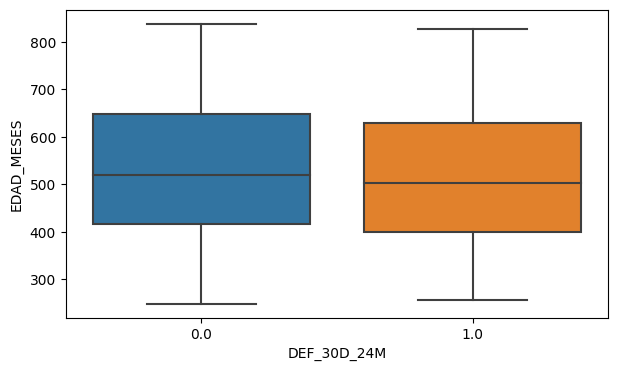

In [72]:
# Si encontramos diferencias en las medianas, podemos decir que es una buena variable predictora
sns.boxplot(x=data[target],y=data[var_name])

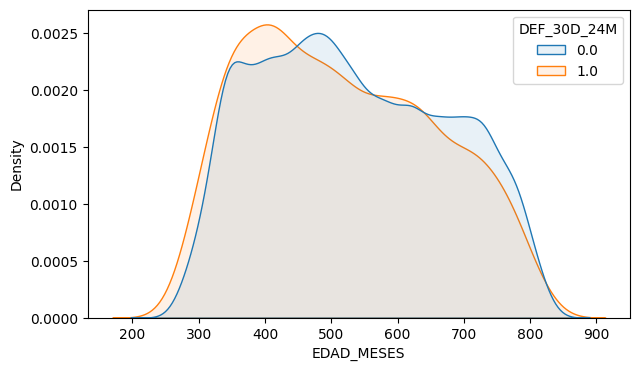

In [73]:
# Grafico de densidad desagregado por la variable objetivo

sns.kdeplot(data, x=var_name, hue=target, fill=True, common_norm=False, alpha=0.1)
plt.show()

In [74]:
#var_name = 'EDAD_ANIOS'
var_name = 'EDAD_MESES'

x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="numerical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

# tener la edad en meses genera un mayor IV

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 330.50)",1942,0.053268,1743,199,0.102472,-0.347905,0.007479,0.000930
1,"[330.50, 425.50)",8090,0.221905,7391,699,0.086403,-0.159596,0.006050,0.000755
2,"[425.50, 647.50)",17320,0.475080,16066,1254,0.072402,0.032404,0.000492,0.000061
3,"[647.50, inf)",9105,0.249746,8537,568,0.062383,0.19208,0.008494,0.001060
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.022515,0.002807


In [1]:
# en python, el valor del woe debemos multiplicarlo por menos 1

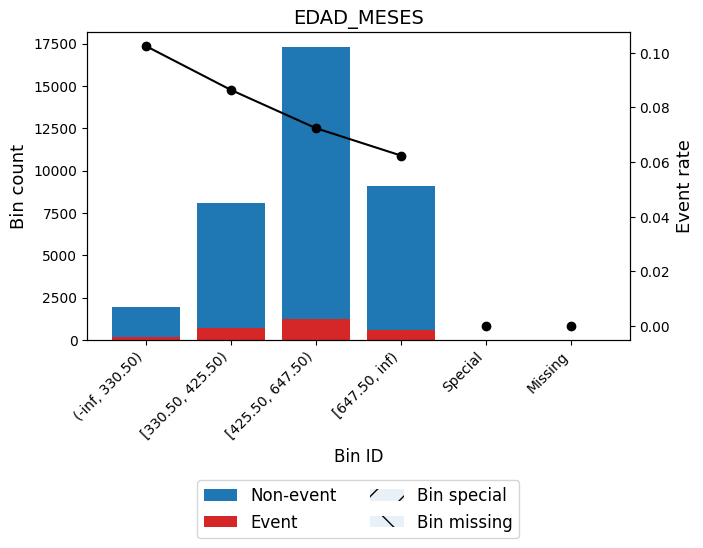

In [75]:
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

In [76]:
# aplicando la transformacion
data['EDAD_MESES_CATWOE'] = optb.transform(data['EDAD_MESES'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['EDAD_MESES_WOE'] = optb.transform(data['EDAD_MESES'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [77]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404


Valores de woe negativos: implica que es un grupo de menor riesgo

In [78]:
# validando la transformacion
#data.groupby(['AGE_CATWOE','AGE_WOE']).agg({'AGE':['max','count']})

In [79]:
# OTROS TIPOS DE TRANSFORMACION: ESTANDARIZACION DE LA VARIABLE EDAD_MESES

media = data['EDAD_MESES'].mean()
desv  = data['EDAD_MESES'].std()

data['EDAD_MESES_ESTAND'] = (data['EDAD_MESES'] - media)/desv

In [80]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697


### - Antiguedad laboral (DAYS_EMPLOYED)

In [81]:
# Dias trabajando
var_name='DAYS_EMPLOYED'

In [82]:
data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
DAYS_EMPLOYED,59262.935568,-1552.0,-15713.0,365243.0,365243.0


<AxesSubplot: >

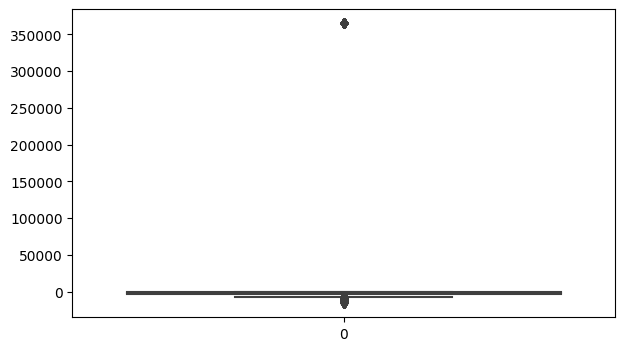

In [83]:
sns.boxplot(data[var_name])

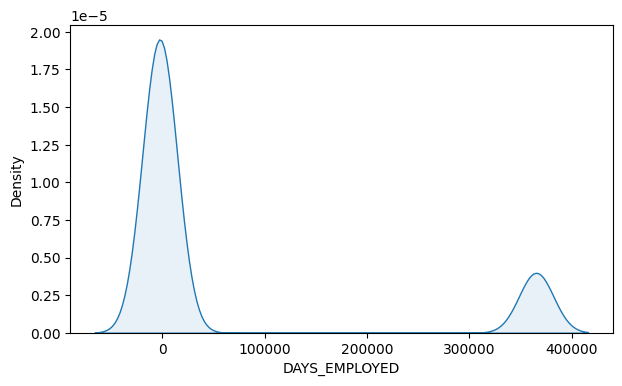

In [84]:
sns.kdeplot(data, x=var_name, fill=True, common_norm=False, alpha=0.1)
plt.show()

In [85]:
# para un mejor entendimiento de la variables, vamos a transformarla

data['ANT_LABO_ANIOS']= -data['DAYS_EMPLOYED']//365	# ANTIGUEDAD LABORAL EN ANIOS
data.loc[data['DAYS_EMPLOYED']>0,'ANT_LABO_ANIOS']=np.nan #SI ES POSITIVO (NO TRABAJA)

data['ANT_LABO_MESES']= -data['DAYS_EMPLOYED']//30	# ANTIGUEDAD LABORAL EN MESES
data.loc[data['DAYS_EMPLOYED']>0,'ANT_LABO_MESES']=np.nan #SI ES POSITIVO (NO TRABAJA)

In [86]:
data[data['DAYS_EMPLOYED']>0].head(4)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES
7,5008812,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0.0,61,748,"[647.50, inf)",-0.19208,1.542451,NaN,NaN
8,5008813,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0.0,61,748,"[647.50, inf)",-0.19208,1.542451,NaN,NaN
9,5008814,F,N,Y,0,283500.0,Pensioner,Higher education,Separated,House / apartment,-22464,365243,1,0,0,0,NaN,1.0,0.0,61,748,"[647.50, inf)",-0.19208,1.542451,NaN,NaN
69,5008884,F,N,Y,0,315000.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-20186,365243,1,0,0,0,NaN,1.0,0.0,55,672,"[647.50, inf)",-0.19208,0.999664,NaN,NaN


In [87]:
#var_name = 'ANT_LABO_ANIOS'
var_name = 'ANT_LABO_MESES'

data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
ANT_LABO_MESES,87.697184,66.0,0.0,523.0,366.0


<AxesSubplot: xlabel='DEF_30D_24M', ylabel='ANT_LABO_MESES'>

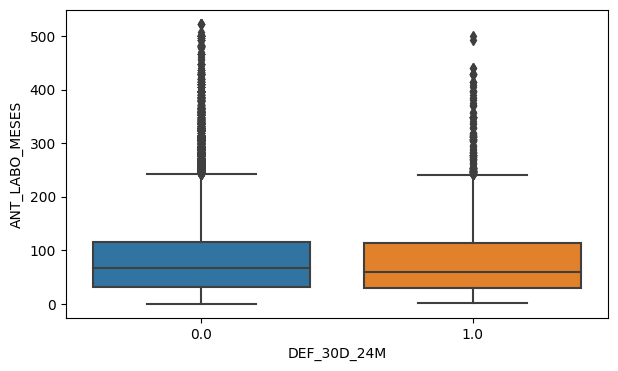

In [88]:
# Si encontramos diferencias en las medianas, podemos decir que es una buena variable predictora
sns.boxplot(x=data[target],y=data[var_name])

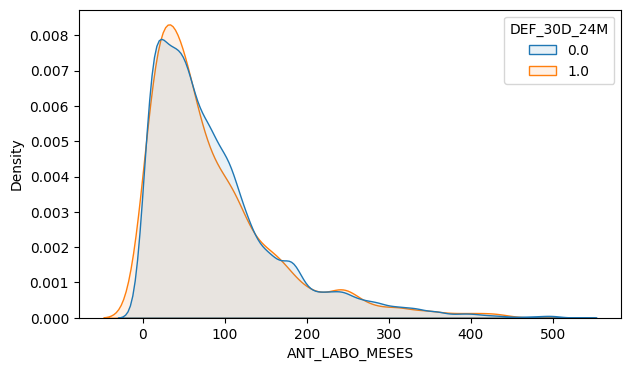

In [89]:
# Grafico de densidad desagregado por la variable objetivo

sns.kdeplot(data, x=var_name, hue=target, fill=True, common_norm=False, alpha=0.1)
plt.show()

In [90]:
#otra opcion de imputacion
#data['ANT_LABORAL'].fillna(data['ANT_LABORAL'].mean(),inplace=True)

In [91]:
#var_name = 'ANT_LABO_ANIOS'
var_name = 'ANT_LABO_MESES'

x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="numerical",monotonic_trend='auto_asc_desc',max_n_bins=3)
optb.fit(x, y)
optb.binning_table.build()

# En riesgos, los missings pueden tener un significado

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 31.50)",7443,0.204158,6791,652,0.087599,-0.174654,0.006709,0.000838
1,"[31.50, 60.50)",6811,0.186823,6255,556,0.081633,-0.097595,0.001855,0.000232
2,"[60.50, inf)",16068,0.440738,14935,1133,0.070513,0.060875,0.001592,0.000199
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,6135,0.168280,5756,379,0.061777,0.202499,0.006333,0.000790
Totals,,36457,1.000000,33737,2720,0.074608,,0.016489,0.002059


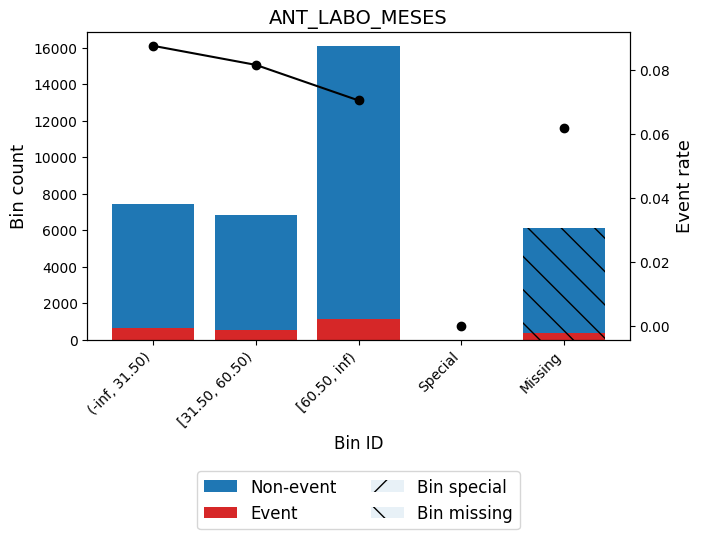

In [92]:
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

In [93]:
# aplicando la transformacion
data['ANT_LABO_MESES_CATWOE'] = optb.transform(data['ANT_LABO_MESES'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['ANT_LABO_MESES_WOE'] = optb.transform(data['ANT_LABO_MESES'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [94]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875


### - Ingresos anuales (AMT_INCOME_TOTAL)

In [95]:
# Dias de nacimiento
var_name='AMT_INCOME_TOTAL'

In [96]:
data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
AMT_INCOME_TOTAL,186685.736662,157500.0,27000.0,1575000.0,560250.0


In [97]:
# para un mejor entendimiento de la variables, vamos a reescalarla
data['AMT_INCOME_TOTAL2'] = (data['AMT_INCOME_TOTAL']/1000)

In [98]:
var_name='AMT_INCOME_TOTAL2'

data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
AMT_INCOME_TOTAL2,186.685737,157.5,27.0,1575.0,560.25


<AxesSubplot: xlabel='DEF_30D_24M', ylabel='AMT_INCOME_TOTAL2'>

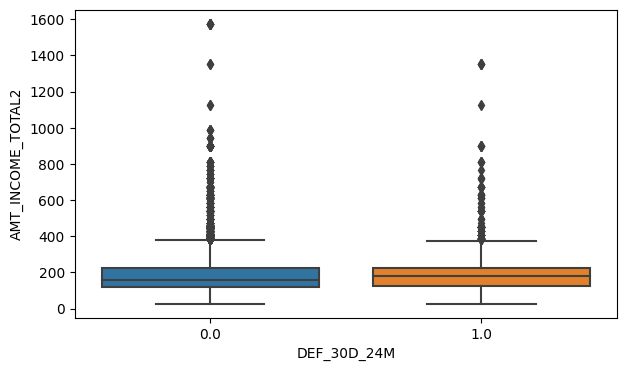

In [99]:
# Si encontramos diferencias en las medianas, podemos decir que es una buena variable predictora
sns.boxplot(x=data[target],y=data[var_name])

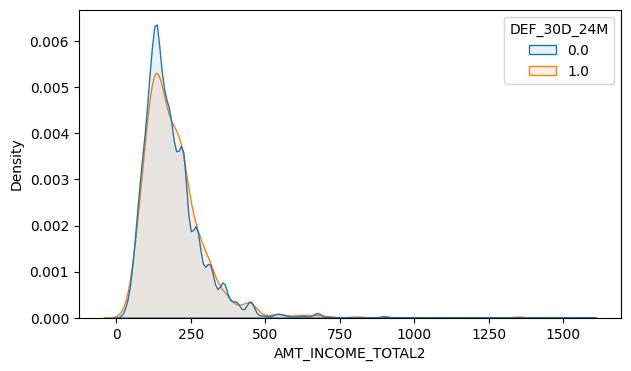

In [100]:
# Grafico de densidad desagregado por la variable objetivo

sns.kdeplot(data, x=var_name, hue=target, fill=True, common_norm=False, alpha=0.1)
plt.show()

# sentido contraintuitivo

In [101]:
var_name = 'AMT_INCOME_TOTAL2'

x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="numerical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 102.38)",5094,0.139726,4766,328,0.064389,0.158286,0.003274,0.000409
1,"[102.38, 194.62)",17805,0.488384,16549,1256,0.070542,0.06043,0.001738,0.000217
2,"[194.62, inf)",13558,0.371890,12422,1136,0.083788,-0.126008,0.006231,0.000778
3,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
4,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.011242,0.001404


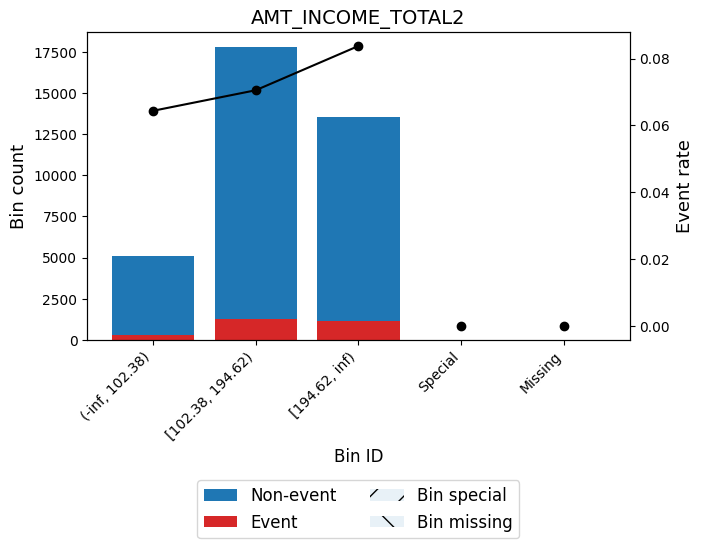

In [102]:
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

In [103]:
# sentido contraintuitivo!! No se utilizará dicha variable

In [104]:
# Tratamiento de atípicos
# procedimieno tradicional
# Valores mayores al percentil 99 colocarles dicho valor
'''
value = data['AMT_INCOME_TOTAL2'].quantile(0.99)
print(value)

data['AMT_INCOME_TOTAL2_P99'] = data['AMT_INCOME_TOTAL2']
data.loc[data['AMT_INCOME_TOTAL2']>=value,'AMT_INCOME_TOTAL2_P99']=value
'''

"\nvalue = data['AMT_INCOME_TOTAL2'].quantile(0.99)\nprint(value)\n\ndata['AMT_INCOME_TOTAL2_P99'] = data['AMT_INCOME_TOTAL2']\ndata.loc[data['AMT_INCOME_TOTAL2']>=value,'AMT_INCOME_TOTAL2_P99']=value\n"

### - Numero de hijos (CNT_CHILDREN)

In [105]:
var_name='CNT_CHILDREN'

In [106]:
data.agg({var_name:['mean',q50,'min','max',q99]}).T

,mean,q50,min,max,q99
CNT_CHILDREN,0.430315,0.0,0.0,19.0,3.0


In [107]:
# Tratamiento de atípicos

# Valores mayores al percentil 95 colocarles dicho valor
value = data['CNT_CHILDREN'].quantile(0.99)
print(value)

data['CNT_CHILDREN_P99'] = data['CNT_CHILDREN']
data.loc[data['CNT_CHILDREN']>=value,'CNT_CHILDREN_P99']=value

3.0


In [108]:
var_name='CNT_CHILDREN_P99'

x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="numerical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 1.50)",32693,0.896755,30273,2420,0.074022,0.008525,0.000065,0.000008
1,"[1.50, inf)",3764,0.103245,3464,300,0.079702,-0.071566,0.000545,0.000068
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.000610,0.000076


In [109]:
# sentido economico no claro e IV muy bajo

### - Estado civil (NAME_FAMILY_STATUS)

In [110]:
var_name = 'NAME_FAMILY_STATUS'

In [111]:
# control de valores a tomar
data[var_name].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Separated',
       'Widow'], dtype=object)

In [112]:
data.groupby(var_name).count()['ID']

NAME_FAMILY_STATUS
Civil marriage           2945
Married                 25048
Separated                2103
Single / not married     4829
Widow                    1532
Name: ID, dtype: int64

In [113]:
x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=5)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Widow, Separated]",3635,0.099707,3393,242,0.066575,0.122569,0.001422,0.000178
1,[Married],25048,0.687056,23234,1814,0.072421,0.032119,0.000699,0.000087
2,[Civil marriage],2945,0.080780,2709,236,0.080136,-0.07746,0.000501,0.000063
3,[Single / not married],4829,0.132457,4401,428,0.088631,-0.187499,0.005044,0.000630
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.007666,0.000957


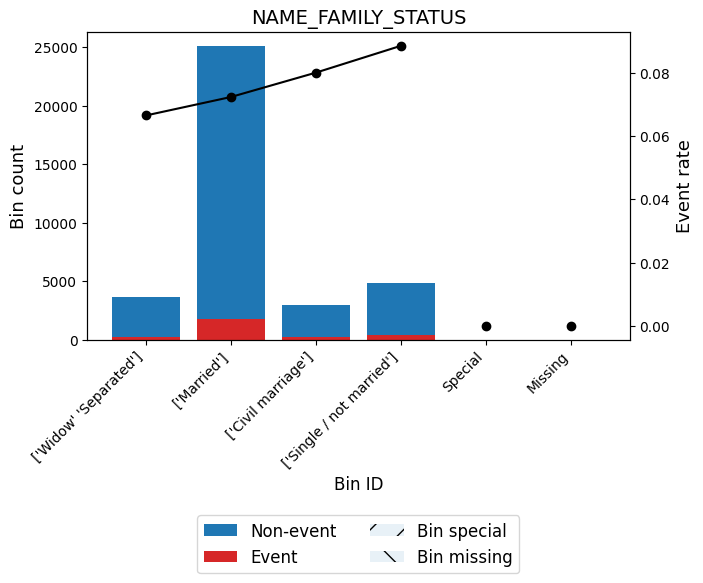

In [114]:
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

In [115]:
# aplicando la transformacion
data['EST_CIVIL_CATWOE'] = optb.transform(data['NAME_FAMILY_STATUS'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['EST_CIVIL_WOE'] = optb.transform(data['NAME_FAMILY_STATUS'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [116]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499


### - Forma de ingresos (NAME_INCOME_TYPE)

In [117]:
var_name = 'NAME_INCOME_TYPE'

In [118]:
data[var_name].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [119]:
data.groupby(var_name).count()['ID']

NAME_INCOME_TYPE
Commercial associate     8490
Pensioner                6152
State servant            2985
Student                    11
Working                 18819
Name: ID, dtype: int64

In [120]:
x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=5)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Pensioner],6152,0.168747,5760,392,0.063719,0.169468,0.004510,0.000563
1,[Working],18819,0.516197,17442,1377,0.073171,0.021011,0.000226,0.000028
2,[Commercial associate],8490,0.232877,7800,690,0.081272,-0.092776,0.002085,0.000261
3,"[State servant, Student]",2996,0.082179,2735,261,0.087116,-0.168597,0.002510,0.000313
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.009331,0.001165


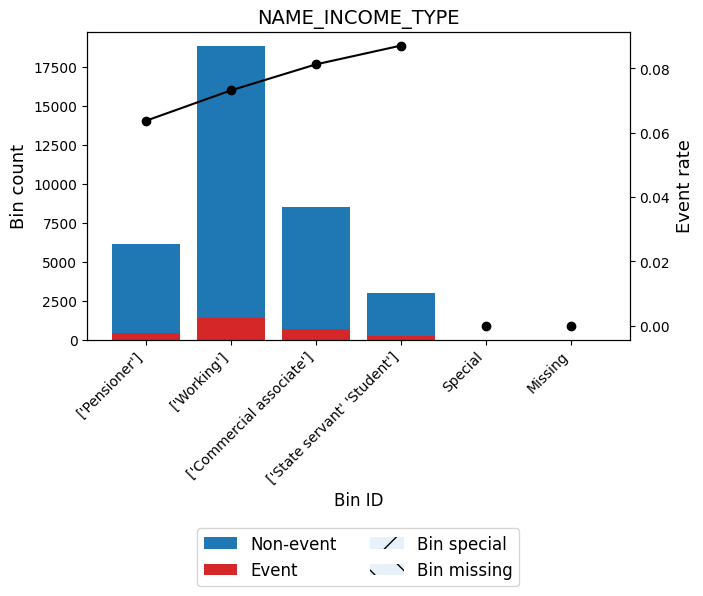

In [121]:
optb.binning_table.plot(metric="event_rate",show_bin_labels=True)

In [122]:
# aplicando la transformacion
data['FORMA_INGRESOS_CATWOE'] = optb.transform(data['NAME_INCOME_TYPE'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['FORMA_INGRESOS_WOE'] = optb.transform(data['NAME_INCOME_TYPE'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [123]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE,FORMA_INGRESOS_CATWOE,FORMA_INGRESOS_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119,['Working'],-0.021011
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776


### - Nivel de educacion (NAME_EDUCATION_TYPE)

In [124]:
var_name='NAME_EDUCATION_TYPE'

In [125]:
data[var_name].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [126]:
data.groupby(var_name).count()['ID']
#data.groupby(var_name).agg({target:['mean','count','sum']})

NAME_EDUCATION_TYPE
Academic degree                     32
Higher education                  9864
Incomplete higher                 1410
Lower secondary                    374
Secondary / secondary special    24777
Name: ID, dtype: int64

In [127]:
x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Lower secondary, Academic degree, Secondary /...",25183,0.690759,23333,1850,0.073462,0.01672,0.000192,0.000024
1,"[Higher education, Incomplete higher]",11274,0.309241,10404,870,0.077169,-0.036511,0.000419,0.000052
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.000610,0.000076


In [128]:
# No se encuentran un ordenamiento claro e IV muy bajo

### - Condicion de vivienda (NAME_HOUSING_TYPE)

In [129]:
var_name = 'NAME_HOUSING_TYPE'

In [130]:
data[var_name].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [131]:
data.groupby(var_name).count()['ID']

NAME_HOUSING_TYPE
Co-op apartment          168
House / apartment      32548
Municipal apartment     1128
Office apartment         262
Rented apartment         575
With parents            1776
Name: ID, dtype: int64

In [132]:
x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Co-op apartment, House / apartment, With pare...",34492,0.946101,31953,2539,0.073611,0.014532,0.000199,0.000025
1,"[Municipal apartment, Office apartment, Rented...",1965,0.053899,1784,181,0.092112,-0.229847,0.003141,0.000392
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.003339,0.000417


In [133]:
# aplicando la transformacion
data['TIPO_CASA_CATWOE'] = optb.transform(data['NAME_HOUSING_TYPE'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['TIPO_CASA_WOE'] = optb.transform(data['NAME_HOUSING_TYPE'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [134]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE,FORMA_INGRESOS_CATWOE,FORMA_INGRESOS_WOE,TIPO_CASA_CATWOE,TIPO_CASA_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119,['Working'],-0.021011,['Co-op apartment' 'House / apartment' 'With p...,-0.014532
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532


### - Profesion (OCCUPATION_TYPE)

In [135]:
var_name='OCCUPATION_TYPE'

In [136]:
data[var_name].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [137]:
data.groupby(var_name).count()['ID']

OCCUPATION_TYPE
Accountants              1241
Cleaning staff            551
Cooking staff             655
Core staff               3591
Drivers                  2138
HR staff                   85
High skill tech staff    1383
IT staff                   60
Laborers                 6211
Low-skill Laborers        175
Managers                 3012
Medicine staff           1207
Private service staff     344
Realty agents              79
Sales staff              3485
Secretaries               151
Security staff            592
Waiters/barmen staff      174
Name: ID, dtype: int64

In [138]:
x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"[Private service staff, Cleaning staff, Sales ...",4380,0.120142,4088,292,0.066667,0.121094,0.001673,0.000209
1,"[Laborers, Drivers, Core staff]",11940,0.327509,11019,921,0.077136,-0.036047,0.000432,0.000054
2,"[Accountants, Cooking staff, High skill tech s...",6616,0.181474,6048,568,0.085852,-0.152602,0.004510,0.000563
3,"[Security staff, Medicine staff, Low-skill Lab...",2198,0.060290,1991,207,0.094177,-0.25429,0.004345,0.000542
4,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
5,Missing,11323,0.310585,10591,732,0.064647,0.154016,0.006902,0.000862
Totals,,36457,1.000000,33737,2720,0.074608,,0.017862,0.002230


In [139]:
# aplicando la transformacion
data['PROFESION_CATWOE'] = optb.transform(data['OCCUPATION_TYPE'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['PROFESION_WOE'] = optb.transform(data['OCCUPATION_TYPE'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

In [140]:
data.head(3)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE,FORMA_INGRESOS_CATWOE,FORMA_INGRESOS_WOE,TIPO_CASA_CATWOE,TIPO_CASA_WOE,PROFESION_CATWOE,PROFESION_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119,['Working'],-0.021011,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Security staff' 'Medicine staff' 'Low-skill ...,0.254290


### - Más variables (testeando IV)

In [141]:
var_name = 'FLAG_OWN_CAR'

x = data[var_name].values
y = data[target]

optb = OptimalBinning(name=var_name, dtype="categorical",monotonic_trend='auto_asc_desc',max_n_bins=4)
optb.fit(x, y)
optb.binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[Y],13843,0.379708,12871,972,0.070216,0.065413,0.001580,0.000197
1,[N],22614,0.620292,20866,1748,0.077297,-0.038315,0.000926,0.000116
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,36457,1.000000,33737,2720,0.074608,,0.002506,0.000313


In [142]:
# aplicando la transformacion
data['EMAIL_CATWOE'] = optb.transform(data['FLAG_OWN_REALTY'], metric='bins', metric_special='empirical', metric_missing='empirical')
data['EMAIL_WOE'] = optb.transform(data['FLAG_OWN_REALTY'], metric='woe', metric_special='empirical', metric_missing='empirical')*(-1)

## 4. Construcción del modelo

In [143]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE,FORMA_INGRESOS_CATWOE,FORMA_INGRESOS_WOE,TIPO_CASA_CATWOE,TIPO_CASA_WOE,PROFESION_CATWOE,PROFESION_WOE,EMAIL_CATWOE,EMAIL_WOE
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016,['Y'],-0.065413
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016,['Y'],-0.065413
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119,['Working'],-0.021011,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Security staff' 'Medicine staff' 'Low-skill ...,0.254290,['Y'],-0.065413
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Private service staff' 'Cleaning staff' 'Sal...,-0.121094,['Y'],-0.065413
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Private service staff' 'Cleaning staff' 'Sal...,-0.121094,['Y'],-0.065413


In [144]:
#list_regressor = ['EDAD_MESES_WOE','ANT_LABO_MESES_WOE','EST_CIVIL_WOE','FORMA_INGRESOS_WOE','TIPO_CASA_WOE','PROFESION_WOE']
list_regressor = ['EDAD_MESES_WOE','ANT_LABO_MESES_WOE','EST_CIVIL_WOE','TIPO_CASA_WOE','PROFESION_WOE','EMAIL_WOE']

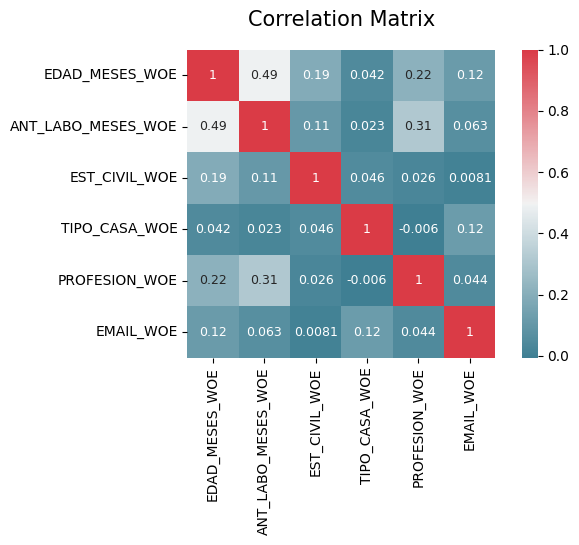

In [145]:
correlation_heatmap(data[list_regressor],'pearson') #limite del 60%

In [146]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

In [147]:
data['INTERCEPT'] = 1

log_clf = sm.Logit(data[target],data[list_regressor + ['INTERCEPT'] ])
classifier = log_clf.fit()
print(classifier.summary2())

Optimization terminated successfully.
         Current function value: 0.263869
         Iterations 7
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.006     
Dependent Variable:  DEF_30D_24M       AIC:               19253.7411
Date:                2023-04-14 22:05  BIC:               19313.2683
No. Observations:    36457             Log-Likelihood:    -9619.9   
Df Model:            6                 LL-Null:           -9675.7   
Df Residuals:        36450             LLR p-value:       9.3832e-22
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
EDAD_MESES_WOE      0.6042   0.1530    3.9494 0.0001  0.3043  0.9040
ANT_LABO_MESES_WOE  0.3726  

In [149]:
#<5% <0.05 QUEDAR variable

In [150]:
data['PROB_PREDICTED'] = classifier.predict(data[list_regressor + ['INTERCEPT']])

In [151]:
data.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,DEF_30D_24M,EDAD_ANIOS,EDAD_MESES,EDAD_MESES_CATWOE,EDAD_MESES_WOE,EDAD_MESES_ESTAND,ANT_LABO_ANIOS,ANT_LABO_MESES,ANT_LABO_MESES_CATWOE,ANT_LABO_MESES_WOE,AMT_INCOME_TOTAL2,CNT_CHILDREN_P99,EST_CIVIL_CATWOE,EST_CIVIL_WOE,FORMA_INGRESOS_CATWOE,FORMA_INGRESOS_WOE,TIPO_CASA_CATWOE,TIPO_CASA_WOE,PROFESION_CATWOE,PROFESION_WOE,EMAIL_CATWOE,EMAIL_WOE,INTERCEPT,PROB_PREDICTED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016,['Y'],-0.065413,1,0.086115
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,1.0,32,400,"[330.50, 425.50)",0.159596,-0.942940,12.0,151.0,"[60.50, inf)",-0.060875,427.5,0,['Civil marriage'],0.077460,['Working'],-0.021011,['Municipal apartment' 'Office apartment' 'Ren...,0.229847,Missing,-0.154016,['Y'],-0.065413,1,0.086115
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0.0,58,715,"[647.50, inf)",-0.192080,1.306767,3.0,37.0,"[31.50, 60.50)",0.097595,112.5,0,['Married'],-0.032119,['Working'],-0.021011,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Security staff' 'Medicine staff' 'Low-skill ...,0.254290,['Y'],-0.065413,1,0.077825
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Private service staff' 'Cleaning staff' 'Sal...,-0.121094,['Y'],-0.065413,1,0.071240
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0.0,52,637,"[425.50, 647.50)",-0.032404,0.749697,8.0,101.0,"[60.50, inf)",-0.060875,270.0,0,['Single / not married'],0.187499,['Commercial associate'],0.092776,['Co-op apartment' 'House / apartment' 'With p...,-0.014532,['Private service staff' 'Cleaning staff' 'Sal...,-0.121094,['Y'],-0.065413,1,0.071240


In [152]:
# indicador GINI
print('GINI DEL MODELO: ',2*roc_auc_score(data[target], data['PROB_PREDICTED'])-1)

GINI DEL MODELO:  0.1161750539205515


In [153]:
0.1161750539205*100

11.617505392049999

In [ ]:
#gini buenos: <40% - MODELOS APPLICANT
#GINI BUENO: <50% - MODELOS BEHAVIOR

Otra solución: https://www.kaggle.com/code/rikdifos/credit-card-approval-prediction-using-ml